# MNIST digit recognizer with pytorch and Kaggle

This notebook develops a convolutional neural network with pytorch to identify hand written digits.


In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

## Fetching the data

Before starting, we must download the data from Kaggle.

We'll store it in a subdirectory; create a `data/` directory if it does not already exist.

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

Then, download the training and test data sets if they do not already exist locally, ensuring that they end up in the `data/` directory. The data are available here: https://www.kaggle.com/c/digit-recognizer/data 

## Munging the data

We need to load the data and produce ndarrays for the training data (divided into a training set and validation set), which can be converted to pytorch tensors, where the inputs are 4d, with dimensions corresponding to 1) sample size, 2) number of channels, 3) width, and 4) height. The labels will be 1 dimensional integer vectors which indicate whether a handwritten digit is a "0", "1", ..., or "9". 

Loading the training data set with pandas, which has one row per example, and the columns represent unrolled pixel intensities.

In [3]:
df = pd.read_csv("data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, extract numeric values which represent intensities (excluding column 0), compute the maximum value for use in normalization later, and jot down the total number of examples.

In [4]:
def cube_data(df):
    """Creates an n-d array from data frame"""
    if "label" in df.columns:
        imgs = df.drop("label", axis = 1).values # iloc: integer indexing, values: numpy ndarray
    else:
        imgs = df.values
    ntot = imgs.shape[0]         # number of rows

    imgs = imgs / 255
    # create a ntrain * 28 * 28 ndarray of training set
    cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")
    for i in range(0, ntot):
        cube[i, 0, :, :] = imgs[i, :].reshape(28, 28)
    return cube

In [5]:
cube = cube_data(df)
ntot = cube.shape[0]

Split the data into a 60/40 training and validation set.

In [6]:
ntrain = np.floor(ntot * .6)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

## Cubing the training data

We've got to un-unroll the data into a 4d numpy array and create our vector of labels, divided into training and validation sets.

(array([ 27182695.,    399808.,    359330.,    306344.,    312800.,
           363558.,    317852.,    362706.,    427725.,   2895182.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

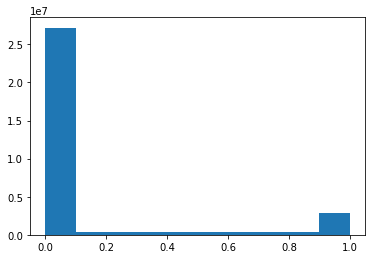

In [7]:
plt.hist(cube.flatten())

In [8]:
# Create a tensor containing the correct labels
labels = df['label'].values

In [9]:
# break data into training and validation sets
train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])

In [10]:
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([25200, 1, 28, 28])
torch.Size([25200])
torch.Size([23038, 1, 28, 28])
torch.Size([23038])


## Creating data loaders

We'll use pytorch's data utilities to create loaders for the training and test data.

In [11]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, 
                                          shuffle = True, num_workers = 4)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, 
                                          shuffle = True, num_workers = 4)

## Visualize some training examples


    2     1     0     6     1     0     8     1     0     0     4     0     2     5     3     0


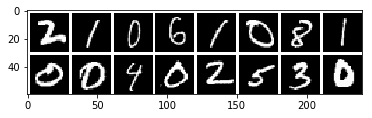

In [12]:
def imshow(img):
    img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%int(labels.numpy()[j]) for j in range(trainloader.batch_size)))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net

Net (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (320 -> 120)
  (fc1_drop): Dropout (p = 0.5)
  (fc2): Linear (120 -> 10)
)

In [14]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())
print(params[4].size())

8
torch.Size([10, 1, 5, 5])
torch.Size([20, 10, 5, 5])
torch.Size([120, 320])


In [15]:
optimizer = optim.Adam(net.parameters())

In [16]:
def train(epoch):
    net.train()
    for batch_index, (inputs, labels) in enumerate(trainloader):
        inputs, labels = Variable(inputs), Variable(torch.squeeze(labels))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_index % 400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * len(inputs), len(trainloader.dataset),
                    100. * batch_index / len(trainloader), loss.data[0]))

In [17]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))
        output = net(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

In [18]:
for epoch in range(4): # loop over the dataset multiple times
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/25200 (0%)]	Loss: 2.315098
Train Epoch: 0 [6400/25200 (25%)]	Loss: 0.697729
Train Epoch: 0 [12800/25200 (51%)]	Loss: 0.390220
Train Epoch: 0 [19200/25200 (76%)]	Loss: 0.189159

Test set: Average loss: 0.1469, Accuracy: 22001/23038 (95%)

Train Epoch: 1 [0/25200 (0%)]	Loss: 0.370475
Train Epoch: 1 [6400/25200 (25%)]	Loss: 0.091279
Train Epoch: 1 [12800/25200 (51%)]	Loss: 0.244566
Train Epoch: 1 [19200/25200 (76%)]	Loss: 0.128772

Test set: Average loss: 0.1073, Accuracy: 22340/23038 (97%)

Train Epoch: 2 [0/25200 (0%)]	Loss: 0.277304
Train Epoch: 2 [6400/25200 (25%)]	Loss: 0.227585
Train Epoch: 2 [12800/25200 (51%)]	Loss: 0.214077
Train Epoch: 2 [19200/25200 (76%)]	Loss: 0.094296

Test set: Average loss: 0.0859, Accuracy: 22424/23038 (97%)

Train Epoch: 3 [0/25200 (0%)]	Loss: 0.433113
Train Epoch: 3 [6400/25200 (25%)]	Loss: 0.201932
Train Epoch: 3 [12800/25200 (51%)]	Loss: 0.024195
Train Epoch: 3 [19200/25200 (76%)]	Loss: 0.343837

Test set: Average loss: 0.0722, Accur

## Predicting labels for the test data

The test data are located in `data/test.csv`, and are formatted similarly to the training data. 

In [19]:
test_df = pd.read_csv("data/test.csv")
test_cube = cube_data(test_df)
ntest = test_cube.shape[0]
test_cube = torch.FloatTensor(test_cube)

In [20]:
pred = net(Variable(test_cube))

In [21]:
type(pred)

torch.autograd.variable.Variable

In [22]:
_, predicted = torch.max(pred, 1)

In [23]:
predicted

Variable containing:
    2
    0
    9
  ⋮   
    3
    9
    2
[torch.LongTensor of size 28000x1]

In [25]:
d = {'ImageId' : pd.Series(np.arange(1, ntest + 1)), 
     'Label' : pd.Series(predicted.data.squeeze().numpy())}
test_df = pd.DataFrame(d)
test_df.to_csv("test-set-predictions.csv", index = False)